### Recommender example

In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_recall_curve
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
sigmoid = lambda x: 1. / (1. + np.exp(-x))

In [4]:
is_numeric = lambda x: isinstance(x, (int, float, complex))
# [(x, is_numeric(x)) for x in [0, 1, 2.345, 'hello', None, {12: 34}, [12, 23]]]

### ttsn model

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# Ruben's version
class TwoTowerModel(nn.Module):
    def __init__(self, users, items, embedding_dim=2, hidden_dims=[], dtype=torch.float32, device='cpu'):
        """users and items dataframes with columns as features."""

        super().__init__()       
        assert users.notnull().all().all() and items.notnull().all().all()
        self.n_users, self.n_items, self.emb_dim = len(users), len(items), embedding_dim
        self.dtype, self.device = dtype, device

        # users, items
        self.id_embeddings = nn.ModuleList([nn.Embedding(self.n_users, self.emb_dim), nn.Embedding(self.n_items, self.emb_dim)])
        self.cat_embeddings = [nn.ModuleList(), nn.ModuleList()]  
        self.cat_metadata = [[], []]  # metadata
        self.cat_features = [[], []]  # users, items
        self.num_features = [[], []]  # users, items
        
        for i, df in enumerate([users, items]):
            for col in df:
                is_num = is_numeric(df[col].iloc[0])
                if is_num:
                    if df[col].var() > 0:
                        self.num_features[i].append(torch.tensor(df[[col]].values, dtype=dtype, device=self.device))
                else:
                    if df[col].nunique() > 1:
                        cat_ids, cat_names = df[col].factorize()
                        emb = nn.Embedding(len(cat_names), self.emb_dim)
                        self.cat_embeddings[i].append(emb)  # store emb as Module
                        self.cat_metadata[i].append({'i': i, 'emb': len(self.cat_embeddings[i]) - 1, 'feature': col, 'categories': cat_names})
                        self.cat_features[i].append(torch.tensor(cat_ids, dtype=torch.long, device=self.device))  # already torch

        self.towers = [
            MLP((1 + len(self.cat_embeddings[i])) * self.emb_dim + len(self.num_features[i]), hidden_dims, self.emb_dim)
            for i in [0, 1]]
        self.to(self.device)  # move model to device


    def forward(self, user_ids, item_ids):

        assert len(user_ids) == len(item_ids)
        # Create towers
        vectors = []
        for i, ids in enumerate([user_ids, item_ids]):
            input = torch.cat(
                [self.id_embeddings[i](ids)] +
                [emb(features[ids]) for emb, features in zip(self.cat_embeddings[i], self.cat_features[i])] +
                [vals[ids] for vals in self.num_features[i]], dim=1)
            vectors.append(self.towers[i](input))

        # Cosine similarities
        # vectors = [torch.nn.functional.normalize(v) for v in vectors]  # L2 norm for cosine similarities
        logits = (vectors[0] * vectors[1]).sum(dim=1)  
        return logits

### demo

In [7]:
dtype = torch.float32
# device = "cpu" 
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [156]:
# Simulate user and item interactions
n_users = 500  # 1000
n_items =  30  # 500
frac_imp = .8  # only have interactions for % of all (user, item) pairs
n_imp = int(frac_imp * n_users * n_items)
true_emb_dim = 4  # using this to simulate true interests
threshold = .6  # 0.5  higher threshold gives fewer positives
print("See %.1f%% of all possible interactions." % (100. * n_imp / (n_users * n_items)))

# 1. Simulate data (no features for now), using numpy
np.random.seed(123)
# user_true_emb = 2 * np.random.randn(n_users, true_emb_dim)
# item_true_emb = 2 * np.random.randn(n_items, true_emb_dim)
# users, items = pd.DataFrame({'dummy': np.zeros(n_users)}), pd.DataFrame({'dummy': np.zeros(n_items)})
# p_true = sigmoid(user_true_emb.dot(item_true_emb.T))  # true proability of user i liking item j
# print(p_true.shape, p_true.mean())

# 2. With features
genders = ['male', 'non-binary', 'female']
users = pd.DataFrame({
    'age': np.maximum(18, 40 + 15 * np.random.randn(n_users)).astype(int),
    'gender': np.random.choice(genders, n_users, p=[.49, .49, .02]),
})
topics = ['food', 'culture', 'civics', 'sports', 'science', 'business']  # just random categories
items = pd.DataFrame({
    'topic': np.random.choice(topics, n_items),  # uniform distribution
})

cat_features = [genders, topics]
cat_emb = {category: np.random.randn(true_emb_dim) for feature in cat_features for category in feature}
emb = np.random.randn(n_users, true_emb_dim) \
    + (users['age'] / users['age'].max()).values.reshape(-1, 1) \
    + np.array(users['gender'].map(cat_emb).tolist())
emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1) 
user_true_emb = emb 
emb = np.random.randn(n_items, true_emb_dim) + np.array(items['topic'].map(cat_emb).tolist())
emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1)
item_true_emb = emb
p_true = sigmoid(user_true_emb.dot(item_true_emb.T))  # true proability of user i liking item j
print(p_true.shape, p_true.mean())

# # 3. User interest modeling
# n_iterests = 2
# item_true_emb = np.random.randn(n_items, true_emb_dim)
# user_true_interests = item_true_emb[np.random.choice(n_items, (n_users, n_iterests))]  # can have duplicate interests
# p_true = sigmoid(user_true_interests.dot(item_true_emb.T).max(axis=1))  # take max to reflect best interest
# p_true = p_true ** 3  # push down distribution a bit
# print(p_true.shape, p_true.mean())
# users, items = pd.DataFrame({'dummy': np.zeros(n_users)}), pd.DataFrame({'dummy': np.zeros(n_items)})  # no features

# Generate data to feed into model, using tensors
# g = torch.Generator(device=device).manual_seed(123) # for reproducibility
# user_ids = torch.randint(0, n_users, (n_imp,), generator=g)  # this includes (user, item) duplicate pairs, so does not work as well
# item_ids = torch.randint(0, n_items, (n_imp,), generator=g)
ipms = torch.randperm(n_users)[:n_imp]
user_ids = torch.cat([torch.full((n_items,), i, device=device) for i in range(n_users)])[imps]
item_ids = torch.cat([torch.arange(n_items, device=device)] * n_users)[imps]
labels = (torch.tensor(p_true, dtype=dtype, device=device)[user_ids, item_ids] > threshold).type(dtype)  # deterministic
# labels = (torch.tensor(p_true, dtype=dtype, device=device)[user_ids, item_ids] > torch.rand(n_imp, dtype=dtype, device=device)).float()  # probabilitic
print(labels.cpu().numpy().mean())
# labels

See 80.0% of all possible interactions.
(500, 30) 0.4609146885495617
0.40758333


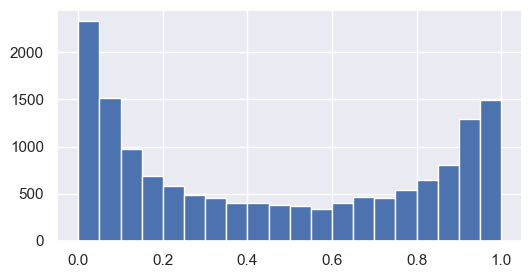

In [157]:
_ = pd.Series(p_true.reshape(-1)).hist(bins=np.linspace(0, 1, 21), figsize=(6, 3))

In [158]:
# torch hyperparameters
lr = 0.01
max_test_loss_increases = 50  # number of epochs
n_epoch_print = 50 # print after every so many epochs

In [159]:
torch.manual_seed(134)
model = TwoTowerModel(users, items, embedding_dim=2, hidden_dims=[3], device=device)

# Training
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train / test split
frac_test = .15
test_idx = torch.rand(n_imp).to(device) < frac_test
train_idx = ~test_idx

# Training loop
stats = []
epoch = 0
test_loss_increases = 0
stop = False
while not stop:
    model.train()
    optimizer.zero_grad()

    uids, iids = user_ids[train_idx], item_ids[train_idx]
    logits = model.forward(uids, iids)
    loss = criterion(logits, labels[train_idx])

    test_logits = model.forward(user_ids[test_idx], item_ids[test_idx])
    test_loss = criterion(test_logits, labels[test_idx])
    
    loss.backward()
    optimizer.step()
    
    stats.append({'epoch': epoch, 'train': loss.item(), 'test': test_loss.item()})
    delta = stats[-1]['test'] - stats[-2]['test'] if len(stats) > 1 else 0
    
    if epoch % n_epoch_print == 0:
        print(f"Epoch {epoch:4}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f} ({delta:5.4f})")
    epoch += 1

    if delta >= 0:  # test loss gets bigger..
        test_loss_increases += 1
        if test_loss_increases > max_test_loss_increases:
            stop = True
    else:
        test_loss_increases = 0  # reset again
        
stats = pd.DataFrame(stats).set_index('epoch')

Epoch    0, train loss: 0.7322, test loss: 0.7229 (0.0000)
Epoch   50, train loss: 0.7021, test loss: 0.7002 (-0.0003)
Epoch  100, train loss: 0.6843, test loss: 0.6885 (-0.0002)
Epoch  150, train loss: 0.6662, test loss: 0.6751 (-0.0003)
Epoch  200, train loss: 0.6426, test loss: 0.6534 (-0.0005)
Epoch  250, train loss: 0.6140, test loss: 0.6246 (-0.0006)
Epoch  300, train loss: 0.5864, test loss: 0.5962 (-0.0005)
Epoch  350, train loss: 0.5618, test loss: 0.5712 (-0.0005)
Epoch  400, train loss: 0.5425, test loss: 0.5509 (-0.0004)
Epoch  450, train loss: 0.5275, test loss: 0.5356 (-0.0003)
Epoch  500, train loss: 0.5167, test loss: 0.5245 (-0.0002)
Epoch  550, train loss: 0.5079, test loss: 0.5151 (-0.0002)
Epoch  600, train loss: 0.5003, test loss: 0.5076 (-0.0001)
Epoch  650, train loss: 0.4940, test loss: 0.5009 (-0.0001)
Epoch  700, train loss: 0.4880, test loss: 0.4945 (-0.0001)
Epoch  750, train loss: 0.4825, test loss: 0.4888 (-0.0001)
Epoch  800, train loss: 0.4780, test loss

In [161]:
# stats = pd.DataFrame(stats).set_index('epoch')
# stats

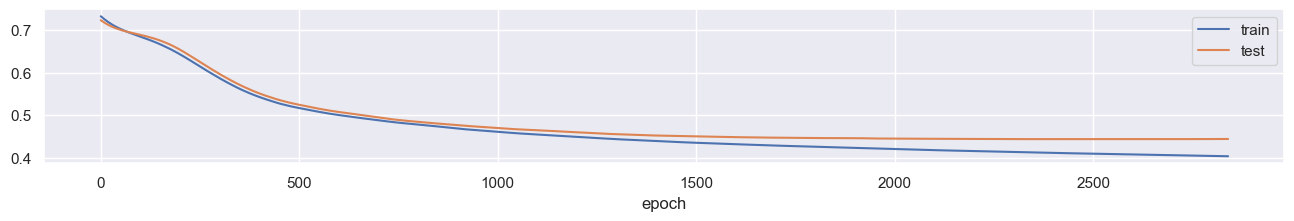

In [162]:
ax = stats.plot(figsize=(16, 2))
# _ = ax.set_xlim(0, len(stats)), ax.set_ylim(0, 1.05 * stats.max().max())
# _ = ax.set_xlim(0, len(stats)), ax.set_ylim(0, 1.05 * stats.max().max())

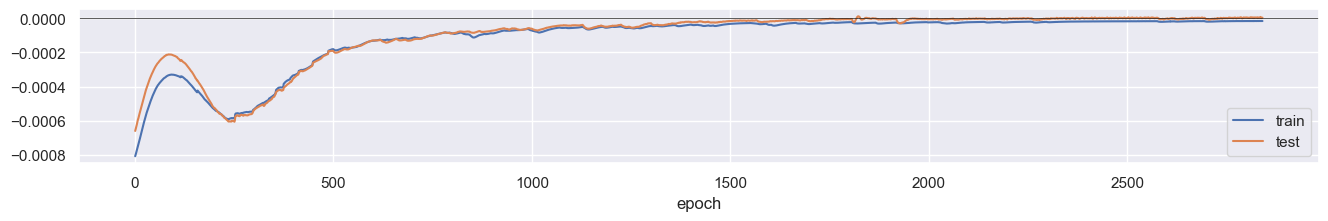

In [163]:
df = stats.diff()
ax = df.plot(figsize=(16, 2))
ax.axhline(0, lw=.5, color='k')
# _ = ax.set_xlim(0, len(stats)), ax.set_ylim(df.min().min() - .05, df.max().max() + .05)

In [164]:
y_pred = sigmoid(logits.cpu().detach().numpy()).round(2)
y_pred_bool = y_pred.round().astype(bool)
y = labels[train_idx].cpu().detach().numpy().astype(bool)

print('prev ', labels.cpu().detach().numpy().mean())
print('train auc %.4f  acc %.4f  ap %.4f  f1 %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred_bool == y).mean(), average_precision_score(y, y_pred), 
       f1_score(y, y_pred_bool), y[y_pred_bool].mean(), y_pred_bool[y].mean()))

y_pred = sigmoid(test_logits.cpu().detach().numpy()).round(2)
y_pred_bool = y_pred.round().astype(bool)
y = labels[test_idx].cpu().detach().numpy().astype(bool)
print('test  auc %.4f  acc %.4f  ap %.4f  f1 %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred_bool == y).mean(), average_precision_score(y, y_pred), 
       f1_score(y, y_pred_bool), y[y_pred_bool].mean(), y_pred_bool[y].mean()))

prev  0.40758333
train auc 0.8743  acc 0.7762  ap 0.8193  f1 0.7299  p 0.7130  r 0.7478
test  auc 0.8617  acc 0.7727  ap 0.8083  f1 0.7337  p 0.7304  r 0.7370


In [165]:
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr)
# p, r, thresholds = precision_recall_curve(y, y_pred)
# plt.plot(r, p)